In [11]:
import os
import sys
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

root_path = os.path.abspath(os.path.join('..'))

if root_path not in sys.path:
    sys.path.append(root_path)

from src.models import Autoencoder
from src.data_loader import extract_tumor_slices, ROIDataset
from src.train import train_autoencoder, get_latent_features
from src.utils import plot_training_results

### Dataset

In [5]:
ROOT_DIR = "../data"
LATENT_DIM = 28
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
metadata_df = pd.read_csv(os.path.join(ROOT_DIR, "UCSF-PDGM-metadata_v5.csv"))
grade_2_3_df = metadata_df[metadata_df["WHO CNS Grade"].isin([2, 3])]
subject_ids = [id_str.split('-')[-1] for id_str in grade_2_3_df["ID"].tolist()]
sample_to_status = dict(zip(subject_ids, grade_2_3_df["1p/19q"].tolist()))

status_mapping = {"relative co-deletion": 1, "co-deletion": 1, "intact": 2}

In [7]:
roi_slices, labels = extract_tumor_slices(ROOT_DIR, subject_ids, sample_to_status, status_mapping)
dataset = ROIDataset(roi_slices, labels)
loader = DataLoader(dataset, batch_size=16, shuffle=True)

Processing NIfTI volumes: 100%|██████████| 99/99 [00:15<00:00,  6.40it/s]


### Model

In [8]:
model = Autoencoder(latent_dim=LATENT_DIM)
train_losses = train_autoencoder(model, loader, n_epochs=10, device=DEVICE)

Epoch 1/10, Loss: 0.016036
Epoch 2/10, Loss: 0.009447
Epoch 3/10, Loss: 0.009447
Epoch 4/10, Loss: 0.009447
Epoch 5/10, Loss: 0.009447
Epoch 6/10, Loss: 0.009447
Epoch 7/10, Loss: 0.009447
Epoch 8/10, Loss: 0.009447
Epoch 9/10, Loss: 0.009447
Epoch 10/10, Loss: 0.009447


In [9]:
features_ae = get_latent_features(model, roi_slices, device=DEVICE)
labels_np = np.array(labels)

X_train, X_val, y_train, y_val = train_test_split(
    features_ae, labels_np, test_size=0.2, stratify=labels_np, random_state=42
)

### Evaluation

In [10]:
clf = make_pipeline(StandardScaler(), LogisticRegression(max_iter=5000))
clf.fit(X_train, y_train)

train_acc = clf.score(X_train, y_train)
val_acc = clf.score(X_val, y_val)
y_val_pred = clf.predict(X_val)

print(f"Accuracy: {val_acc:.4f}")

Accuracy: 0.9006


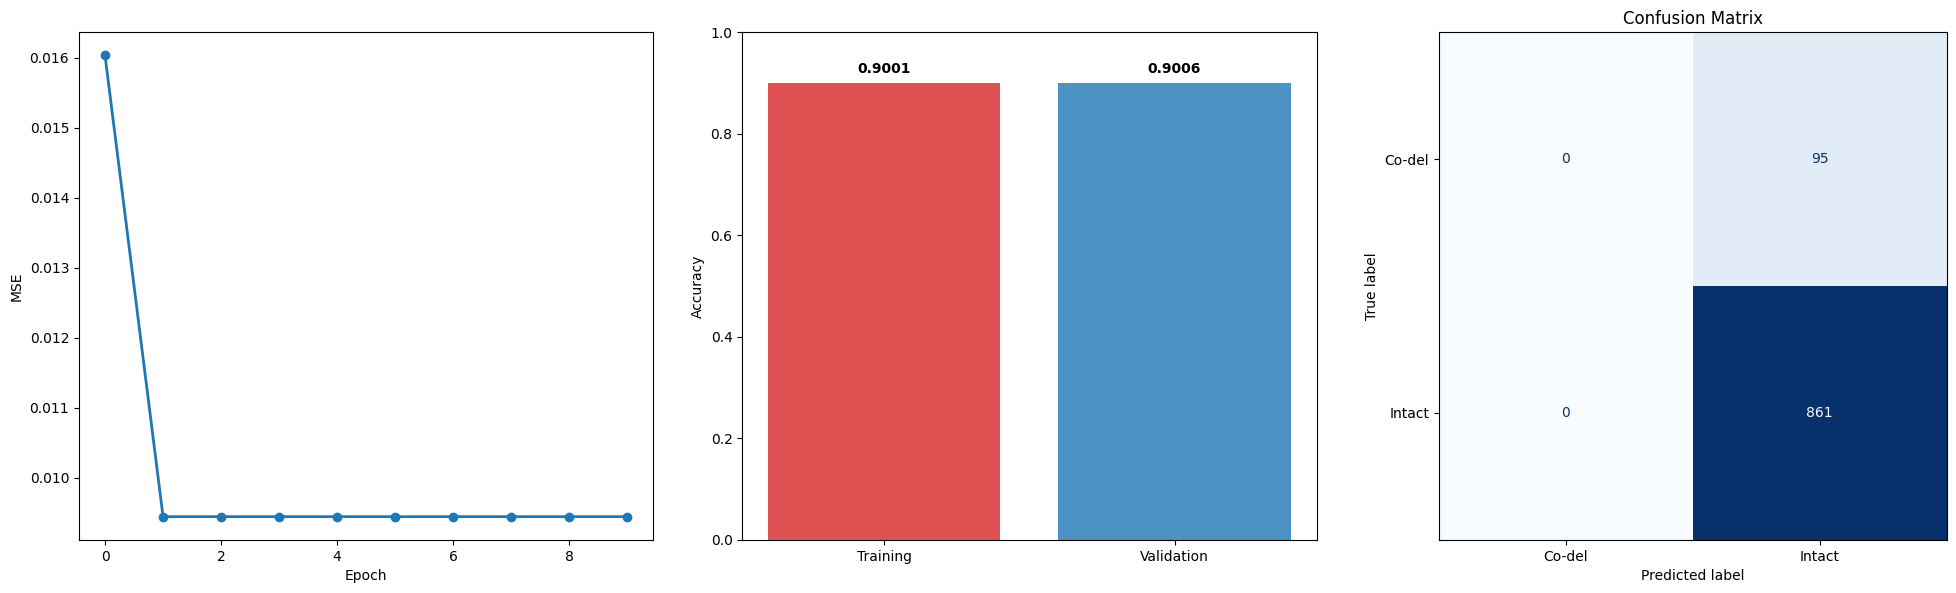

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

# loss
axs[0].plot(train_losses, marker='o', color='tab:blue', linewidth=2)
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("MSE")
axs[0].grid(False)

# accuracy
labels = ['Training', 'Validation']
accuracies = [train_acc, val_acc]
axs[1].bar(labels, accuracies, color=['tab:red', 'tab:blue'], alpha=0.8)
axs[1].set_ylim(0, 1.0)
axs[1].set_ylabel("Accuracy")
for i, v in enumerate(accuracies):
    axs[1].text(i, v + 0.02, f"{v:.4f}", ha='center', fontweight='bold')

# confusion matrix
cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Co-del", "Intact"])
disp.plot(ax=axs[2], cmap="Blues", colorbar=False)
axs[2].set_title("Confusion Matrix")

plt.tight_layout()
plt.show()